## 1) Coding environment setup 

The *requirements.txt* file provided consists of a list of packages that might be useful for the completion of this task. These packages can be installed by running **pip install -r requirements.txt** in the terminal and the packages can then be loaded manually within the relevant scripts. However, you are welcome to install and load any packages that you see as necessary.


In [31]:
## TODO: Import libraries 
from IPython.display import Image
import pandas as pd
import requests as rq
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

## 2) Data Analysis

#### The file *outcome.csv* contains the results of EPA investigations of air pollution violations by firm. Each row includes a unique firm identifier, the year the firm was inspected, and a binary outcome from the inspection. A separate file, *unclean.csv*, contains additional firm-level variables which are constant across years. There are some issues with the data in both of these files which will need to be addressed in the course of the following analyses. 

#### 1. Resolve the following issues to process the data:  
- Join the firm characteristics (*unclean.csv*) to the panel of inspection outcomes (*outcome.csv*). Some facilities appear in only one of the datasets. Ensure the join accounts for these cases without losing data integrity. Describe how you handle mismatches. IMPORTANT: Do NOT edit or address any missing values or perceived errors in the binary outcome variable provided in *outcome.csv*.
- Identify and remove duplicate observations. Duplicates may not be exact matches but could have slight variations (e.g., capitalization or extra spaces). Explain how you identify duplicates.
- Clean string data for the state variable (i.e., standardize capitalization and remove leading and trailing white space). Hint: you should end up with seven categories.
- Identify and handle implausible data values. Please briefly describe the logic behind the decisions that you make. If you decide to address potential outliers, make sure you explain your criteria for identifying them. 
- Write a brief paragraph that explains the choices you have taken during your entire data cleaning exercise.

Save the cleaned and merged dataset in the *output/* directory with the name *cleaned.csv*.

In [69]:
#Read in csv files
outcome = pd.read_csv("C:/Users/tony-/OneDrive/Documents/eel-coding-test-intern-python/eel-coding-test-intern-main-2/data/outcome.csv")
unclean = pd.read_csv("C:/Users/tony-/OneDrive/Documents/eel-coding-test-intern-python/eel-coding-test-intern-main-2/data/unclean.csv")
outcome.head()

#Join both data frames into one
#Outer join ensures data integrity by preserving entries that don't have corresponding registry_id in other data frame
#This will produce many null values
df = unclean.merge(outcome, how = 'outer')
df.head(30)

#finds which rows have duplicate registry id's
#searching over registry_id ensures will count duplicates even if capitalization differences in other categories such as state
duplicates = df[df.duplicated(['registry_id'])]
len(duplicates)

#drops duplicates from df resulting in 10 less rows which corresponds to the 10 duplicates we found earlier
df = df.drop_duplicates('registry_id')
df


df['state'].head(20)
#strips leading/trailing whitespaces
df['state'] = df['state'].str.strip()

#Standardize capitalization
df['state'] = df['state'].str.upper()

#Change all labels to two letter initials
df.replace(['CALIFORNIA', 'CALIF.'], 'CA', inplace = True)

df['state'].unique()

#Summary Statistics
df.describe()
df.isnull().sum()


#Upon looking at some statistics, the maximum median earning appeared to be an outlier
#and maximum white percentage in the population was over 100% which is not possible

#To address high median earning:
#Calculated z-score to determine how far away from mean maximum value is assuming an 
#approximate normal distribution since we have a large sample size
average = df['earnings_median'].mean()
stdev = df['earnings_median'].std()
pct99th = df['earnings_median'].quantile(0.99)
z_score = (pct99th - average) / stdev
z_score
# Since z=3.24 it may be worth anyting past 99th percentile
df = df[df['earnings_median'] <= pct99th]

pct99th = df['earnings_median'].quantile(0.99)
z_score = (pct99th - average) / stdev
z_score
#new z-score much lower


#To address white population over 100%:
error = df[df['pct_white'] > 100]
error

#could try to find correct pct_white value under the assumption other percentages are correct
white_pct = 100 - error['pct_black'] - error['pct_native'] - error['pct_asian'] - error['pct_hi_pi'] - error['pct_other']
white_pct

#However since one input is not reliable, I choose to delete this row since the data is unreliable
df = df[df['pct_white'] <= 100]

df.isnull().sum()
df = df.reset_index()

df.to_csv('cleaned.csv')
df

,index,registry_id,year,state,prev_yr_se_viols,prev_yr_se_hpviols,region_code,pct_white,pct_black,pct_native,pct_asian,pct_hi_pi,pct_other,earnings_median,total_population,violation
0,0,110000442405,2022,FL,0.0,0.0,63620,52.995802,45.143277,1.496828,0.000000,0.000000,0.364093,21673.058671,1319.0,1
1,1,110000477467,2022,MO,0.0,0.0,92881,38.596998,44.217552,0.498304,8.569447,0.965572,7.152126,56535.000000,32694.0,0
2,2,110000479330,2022,KY,0.0,0.0,92337,31.416443,28.302860,1.549682,5.860481,0.340084,32.530450,41092.000000,39600.0,0
3,3,110000479401,2022,KY,0.0,0.0,92374,54.664739,24.040758,1.193881,7.517278,0.671245,11.912098,43144.000000,44131.0,0
4,4,110000485190,2022,MO,0.0,0.0,95341,35.020417,29.374628,0.893389,8.577359,0.080840,26.053366,30022.000000,34047.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,505,110071252852,2022,FL,0.0,0.0,64840,65.696940,30.335691,2.667327,0.000000,0.089658,1.210384,41125.968193,3049.0,1
466,506,110071253777,2022,CA,0.0,0.0,33767,59.498741,38.589217,0.267185,1.210682,0.000000,0.434175,62795.000000,7493.0,0
467,507,110071254888,2022,FL,0.0,0.0,64842,56.810731,30.161244,4.485058,3.986718,0.000000,4.556249,32875.000000,894.0,0
468,508,110071277971,2022,KY,0.0,0.0,91367,57.036288,25.728421,0.718484,12.593421,0.311010,3.612376,57293.000000,45074.0,0


I first chose to merge the two data frames using outer join in order to follow the directions of preserving all missing values (However, using inner join could also remove values that had no intersection between data frames. I then remove duplicate entries on the registry_id to ensure all duplicate firms are deleted, regardless of the format their 'state' values take. Next, I clean the state column values by removing whitespaces, standardizing capitalization, and changing all entries to two letter state initials. To proceed, I deleted outliers by removing the top 99th percentile in 'earnings_median' since there was an unusually high maximum. Lastly, there was an error in one of the entries where a white population percentage was over 100 so I deleted the entry. I then ensured there were no more missing values in the dataframe to have a fully cleaned data set.

#### 2. Create a nicely-formatted table of summary statistics by state for the three states with the most facilities in the dataset. 
- Based on the summary statistics, what insights can you draw about these three states?
- Why did you choose these particular statistics and why do you think these particular statistics are important in understanding this dataset?

In [63]:
#Find the top three states with most observations
df['state'].value_counts()[0:3]

#Three states with most facilities are Florida, California, and Missouri
#Gropuby state and find some some statistics
table = df.groupby(['state'])[['pct_white', 'pct_black', 'pct_hi_pi',
                               'earnings_median', 'total_population', 
                               'violation']].agg(
                                    ['mean', 'min', 'max','std'])
#Choose only top three states
table = table.loc[['CA', 'FL', 'MO']]

#Reformatting table and rounding for neater display
table = table.stack(future_stack = True)
table = table.round(3)
table

pct_white  pct_black  pct_hi_pi  earnings_median  \
state                                                          
CA    mean     54.349     39.269      0.145        35722.984   
      min      16.147      8.624      0.000        16552.682   
      max      85.032     76.929      1.369        69505.378   
      std      12.254     12.453      0.228         9067.283   
FL    mean     58.125     35.780      0.148        35546.627   
      min      16.325      7.288      0.000        14643.194   
      max      89.551     82.400      2.433        77427.000   
      std      13.802     10.864      0.335        10810.069   
MO    mean     42.461     34.534      0.837        44065.624   
      min      10.003     11.886      0.000        18906.000   
      max      68.578     49.068     16.449        69059.000   
      std      15.250      8.852      2.223        11793.814   

            total_population  violation  
state                                    
CA    mean         27735.557      0.443  
      min           2327.000      0.000  
      max          75705.000      1.000  
      std          15394.459      0.498  
FL    mean         18001.854      0.286  
      min             93.000      0.000  
      max         110750.000      1.000  
      std          19313.011      0.453  
MO    mean         34716.148      0.111  
      min            533.000      0.000  
      max          97249.000      1.000  
      std          22351.922      0.317

Based on these summary statistics, we can see that out of California, Florida, and Missouri, Californian firms have the most environmental violations with an average of about 44% of firms facing a violation in 2022. According to the data, among the three states, Florida also has a district with the highest white population and another with the highest black population. On average, Missouri districts make more money than the other two states, but Florida has the highest earning district. That being said, the top earning districts in the data were omitted to remove outliers.

The mean, minimum, and maximum are three useful statistics when trying to understand a data set. The mean is especially useful in understanding the average distribution of a variable for the given state. For example, it is interesting to know the mean violations per state to know which states have firms that are more likely to have environmental violations. The minimum and maximum are also useful to locate outliers or understand the range of the data. Having the mean for the percentage of an ethnic group in a state is useful, but knowing the maximum or minimum percentages can also give a better picture of what the states ethnic distribution looks like. The standard deviation can also be useful to compare how much variation there is between the data for each variable. For instance, some states may have a higher variation in median income than others.

#### 3. The E&E Lab wants to use the data from the previous inspection cycles (your cleaned data) to make a prediction about how likely it is that each firm that they intend to inspect next year shows a violation. Run a regression to see what factors are important predictors of violations. Create a nicely-formatted table displaying the output of your model.  

In [42]:
#X includes all variables we are running the regression for
X = df[['earnings_median', 'prev_yr_se_viols', 'prev_yr_se_hpviols', 
        'pct_white', 'pct_black', 'pct_native', 'pct_asian', 'pct_hi_pi', 
        'pct_other', 'total_population']]

#y is includes the dummmy violation which is our dependent variable
y = df['violation']

#Using a Logistic regression since our dependent variable is a dummy
model = sm.Logit(y, X)
result = model.fit()

# print(result.summary())

#Iterating through p-values to find statistically significant variables on violation
var_list = []
for idx, p in enumerate(result.pvalues):
    if p < 0.05:
        # print(idx)
        # print(p)
        var_list.append(idx)

result.pvalues.iloc[var_list]
#Returns earnings, white, black, hispanic and other populations percentages
#as variables statistically significant on violation

X = df[['earnings_median', 'pct_white', 'pct_black', 'pct_hi_pi', 'pct_other']]
model = sm.Logit(y, X)
result = model.fit()
# print(result.summary())

#After running second regression hispanic population resulted with high p-value
#Running again without hispanic population
X = df[['earnings_median', 'pct_white', 'pct_black', 'pct_other']]
model = sm.Logit(y, X)
result = model.fit()

#Creates table summarizing regression output with statistically significant variables
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.430963
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.439639
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.440844
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              violation   No. Observations:                  470
Model:                          Logit   Df Residuals:                      466
Method:                           MLE   Df Model:                            3
Date:                Thu, 27 Feb 2025   Pseudo R-squ.:                  0.2904
Time:                        15:22:38   Log-Likelihood:                -207.20
converged:                       True   LL-Null:                       -292.01
Covariance Type:            nonrobust   LLR p-value:                 1.533e-36
                      coef    std err          z      P>|z|  

C:\Users\tony-\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Since the variable we are regressing against is a categorical dummy variable, I chose a logistic regression. After running the first regression, there were five variables that heald statistically significant p-values below 0.05. I ran the model with these 5 variables and noticed that the percentage of hispanic population now had a p-value higher than 0.05. I ran the regression a third time with the four remaining significant variables. These variables were median earnings, percentage of white, black and other populations (not white, black, native american, asian, hispanic). Lastly, I displayed a table summarizing the regression output of these four variables

#### 4. Identify an interesting correlation in the data between the outcome of interest and a covariate and produce a nicely formatted graph illustrating that relationship. Give a brief explanation of what your figure displays and discuss possible interpretations. Additionally, make sure to address the following considerations: 
- What are potential pitfalls in interpreting this correlation? 
- How might confounding factors or sample bias influence the results?


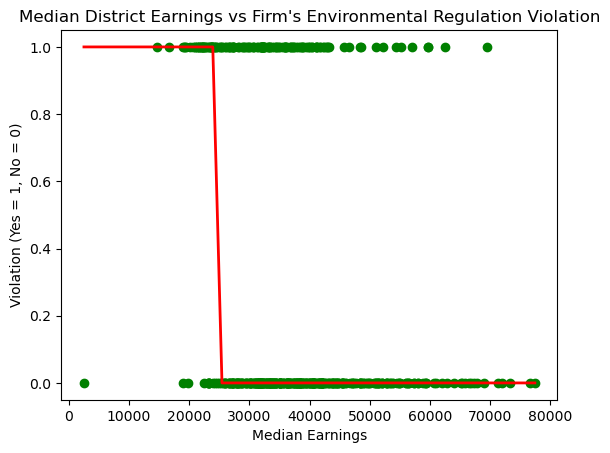

In [48]:
x_ax = df['earnings_median']
y = df['violation']

#Reformat values to fit in scikitlearn logistic regression model
X = x_ax.values.reshape(-1, 1)
Y = y.values
mod = LogisticRegression()
mod = mod.fit(X, y)

#This model is easy for running predictions
#Testing a series of evenly spaced generated x values to create a line of best fit
X_fit = np.linspace(min(X), max(X), num = 50)
y_fit = mod.predict(X_fit)

#Plotting the points of earnings on violations along with line of best fit
plt.scatter(X, y, color = 'green')
plt.plot(X_fit, y_fit, color = 'red', linewidth = 2)
plt.title("Median District Earnings vs Firm's Environmental Regulation Violation")
plt.ylabel("Violation (Yes = 1, No = 0)")
plt.xlabel("Median Earnings")
plt.show()

There are four variables with statistically significant correlations to violations, but I chose median earnings. The figure displays a negative relationship where lower earning districts tend to have more violations than those with higher earnings. These lower earning districts most likely have firms making less money, so firms may have an incentive to cut corners and ignore environmental regulations. Just looking at this relationship runs the risk of omitted variable bias. There are likely other variables that are associated with lower earning districts but are also leading to higher environmental regulations. For example, districts earning less may be in areas that are less educated and firms there either do not know or do not see the purpose of environmental regulation. If this were the case, it would be misleading to view income as a reason for environmental violations.

There could also be a sample bias since EPA agents may tend to monitor higher earning regions more than the lower earning ones, incentivizing firms in this area to operate according to regulations more than in lower income areas. EPA agents may do this for equity reasons or because bigger firms could be operating in high income areas vs small businesses in low income.

## 3) Regression Analysis and Causal Inference 

#### Next, you have an opportunity to demonstrate your understanding of econometrics and empirical research design for economic problems.      

#### 1. A partner whom the Lab is working with wants to find out whether employing a new type of air scrubber technology helps reduce emissions of a particular pollutant. They find that some of the facilities that they inspect already employ this technology and propose to the E&E Lab that we compare violation rates between firms with this technology and firms without it. Write a brief paragraph about how you would respond to the partner’s suggestion.  

In this situation, a difference in difference (diff in diff) technique is the best way to analyze this type of data and infer some causal effect. Diff in diff is used when you cannot assume the treatment (using air scrubber technology) and the control group (not using technology) are exchangeable, meaning randomization is not possible. This is because firms that previously chose to employ the technology, may have been affected by other confounding variables that cause change in both adopting the technology and violation rates. We would require pre and post intervention (adopting the technology) panel data to compare both groups before and after adopting the technology. Inferring causality in a diff in diff model also has some strict requirements and may require some assumptions where reasonable. For example, the intervention should be unrelated to the outcome at baseline, that is, firms should not be adopting the technology after receiving violations. Moreover, there should be no spillover effects, so if one firm adopts the technology, another firm without the treatment should not be experiencing effects on its violation rate. Maybe the most important requirement to meet is the parallel trend assumption that states, in absence of treatment, or the counterfactual, the difference between treatment and control groups should be constant over time and not already increasing or decreasing. Unfortunately, we cannot observe this change, but it is possible to look at years before the technology was adopted to check if both groups were experiencing parallel (constant) changes in violation rates and we could also try to focus on shorter time periods where there is less chance of an exogenous change. That being said, with a thorough analysis of the data, we may be able to meet these assumptions, in which case we can find the difference between treatment and control groups pre-intervention and subtract that from the difference between groups post-intervention, to estimate the causal effect of some variable on violation rates.

#### 2. The partner now decides to run a field experiment with the E&E Lab. After the experiment concludes, your colleague at the Lab produces the following regression table. You have been asked to present this table to the partner during an upcoming meeting. What do you see in the table? How do you explain the results to the partner (keeping in mind that the partner may not have as strong of a grasp of econometrics as you do)?

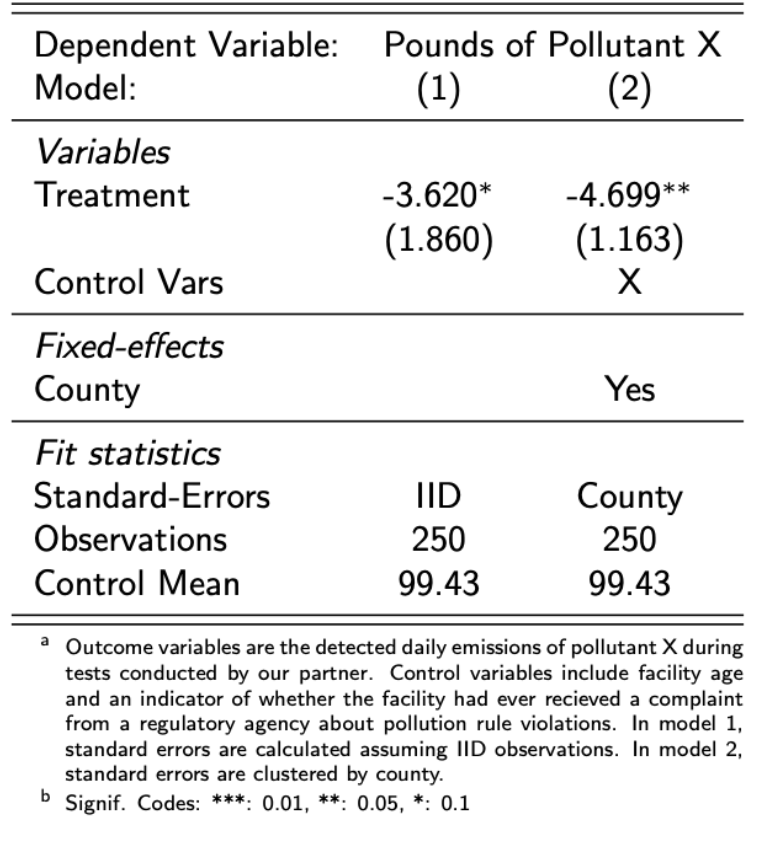

In [56]:
# run cell to display image
Image(filename="./images/reg_1.png", width=300)

# If the image doesn't load due to path issues, kindly refer to the image named "reg_1.png" in 
# the "images/" directory.

Running field experiments is a great way to infer causality and can cover many biases from confounding variables if done right. In this table we see the results of two models with slightly different controls to observe the change in pounds of a pollutant X based on adoption of the air scrubber technology. By looking at the first model, we observe a decrease of 3.62 pounds of pollutant X when a firm employs the technology with a standard deviation of 1.85 pounds. This is based on data from 250 firms that emit an average of 99.43 pounds of pollutant without the technology. Standard-errors IID means they are independent and identically distributed. That is, each firm's deviations from the control mean are not correlated to another firm's (independent) and all firms have the same probability of deviating some amount from the mean, with all of them polluting an average of 99.43 pounds without the technology (identically distributed). IID observations can be derived from a random sample, which is usually a reasonable assumption under an experiment such as this one. 


The second model returns a decrease in 4.699 pounds of pollutant X for employing the technology, with a standard deviation of 1.163 pounds. This change is slightly greater due to the additional control variables implemented. Therefore, in addition to checking the effects of the technology on firms' emissions, the model is also observing the changes from another set of variables. This is done to avoid omitted variable bias, which is when there is another variable besides the air scrubber technology in this case, that is leading to changes in pollution as well as changes in the technology adoption. In addition, the model is controlling for county fixed effects which means the model is accounting for characteristics that do not change over time, but are different in each county. County fixed effects can be good to control for if there are some countries that have characteristics that in some way affect firms' emissions and technology adoption. Since we are controlling for changes in county characteristics, the second model also looks at clustered standard errors by county, meaning the standard errors are reported based on deviations of the entire county from the mean instead of each individual firm.


Due to the additional controls in the second model, there are three asterisk next to the treatment effect (-4.699***) which implies the result is statistically significant at the 1% level compared to the previous model only being significant at the 10% level. Statistically significant at the 1% level implies that the probability of the true population mean pollution by firms being 4.699 away from 99.43 is less than 1%. Therefore, our result is highly likely to represent a decrease in pollution due to the technology. 


#### 3. In Model 2, your colleague includes fixed effects for the county in which a facility is located. What might be their motivation for doing so? 


There may be differences in each county that are time-invariant, but make it more likely to adopt the technology and experience a change in pollution. For example, some counties may have always had stricter environmental regulations. It is possible that in this country firms may have felt a higher incentive to purchase the air scrubbing technology regardless of the treatment and due to environmental regulations may have been trying to restrict their emissions. If this were the case, county fixed effects would be an effective way to control for these characteristics that may otherwise overestimate the change in pollution due the technology.

## 4) Predictive Workflow 

#### Examine Figure 1 in the included paper “Wildland- urban fire disasters aren’t actually a wildfire problem” by Calkin et al. (2023). A partner asks you to design a predictive model about fire hazard using this framework. Write a brief paragraph outlining how you would approach the development of this predictive model. Your response should be open-ended, but consider addressing the following: 
- What type of model might be appropriate for this problem (e.g., machine learning, statistical, hybrid, etc.)? 
- What data sources would you rely on to build this model, and what might be the challenges in acquiring or extracting predictors from this data? 
- How would you decide which variables or predictors are relevant for predicting fire hazards? 
- How would you assess the model’s effectiveness or performance in a real-world scenario? 

Feel free to draw on your previous experiences from both classroom projects and professional settings or explore any other relevant approaches you think could apply to this task. 

If we wanted to build a predictive model based on the framework in figure 1, a machine learning approach would be best. Machine learning methods have the best predictive capabilities while statistical methods are better for identifying variables that are correlated or may cause a change in another variable. In the paper, Calkin points out the conditions that lead to fire disasters, meaning a statistical method would be less useful if we were just looking at the paper. However, using a hybrid approach may help identify other environmental conditions that increase fire risk.

This model would require environmental data on humidity and wind speed in the region as outlined in the first box of the figure. We would also require data on the density of ignitable structures and vegetation, as well as the rate at which a pre-existing fire is spreading if there is one. Lastly, we would need data on whether a fire occurred in the area or not in order to train and test the model. Current weather data and fire occurrences is typically accessible, but it may be difficult to find data on the density of structures or vegetation as it simply may not exist. The rate a pre-existing fire is spreading may be something that can be calculated using data from fire suppression teams, however, by the time data is collected and processed for a pre-existing fire, the results may come too late to preemptively predict fire risks.

Regressing a variety of past environmental variables on regions where fires have started may be a good way to see which variables are correlated with fire risk. Researching more papers such as Caulkin's can also help identify factors that tend to lead to increased fire risk.

While building the model you would want to split the data into a training and testing group. For example, the model could be built with 70% of the data while 30% is used for testing. The machine learning model would get very good at predicting the training dataset, but testing the model on the testing dataset it has never seen will allow us to test its effectiveness on more randomized real world data. It would probably also be useful to test the model in different regions or continue to track the model's performance even after it is complete to see if it is producing accurate fire risk prediction.


### This marks the end of the coding assessment. Please make sure to generate a PDF or HTML file of this notebook and save it in the *output/* directory with the name *responses.pdf* or *responses.html*.                       